In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree

In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c2 = df[selected_columns].copy()
#get projects not in cluster
c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
#combine into one list
c2 = c2[c2['name_with_owner'].isin(c2_cols)]
c2 = c2.drop(columns = 'name_with_owner')

In [3]:
c2

,is_core,repos,gists,followers,following,months_experience,has_bio
15,0,68,2,167,87,97.59,1
42,0,38287,0,503,0,111.12,0
116,0,2749,0,747,8,85.70,1
142,0,12,1,5,2,45.65,0
199,0,16,0,79,27,97.63,1
...,...,...,...,...,...,...,...
7329,0,26,0,37,49,105.15,0
7330,0,6,0,0,0,109.57,0
7331,0,95,10,28,22,90.98,1
7332,0,27,0,30,93,85.10,0


In [4]:
X = c2.drop(columns = 'is_core')
y = c2['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
5759,3,0,1,0,99.20,0,0
6084,5,0,0,0,80.57,0,0
6121,35,1,37,7,86.98,0,0
4173,3,0,281,0,113.63,0,0
4738,87,2,24,22,104.60,1,0
...,...,...,...,...,...,...,...
5812,357,29,141,3,148.61,1,0
1048,313,135,126,0,166.85,1,0
6014,29,0,35,2,71.26,1,1
4553,8,0,0,0,92.09,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    440
1     34
Name: is_core, dtype: int64
0    111
1      8
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c2_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c2_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c2_train['has_bio'] = c2_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c2_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,3,0,1,0,99.200000,0,0
1,5,0,0,0,80.570000,0,0
2,35,1,37,7,86.980000,0,0
3,3,0,281,0,113.630000,0,0
4,87,2,24,22,104.600000,1,0
...,...,...,...,...,...,...,...
882,28,0,34,2,72.255968,1,1
883,20,0,15,2,89.675413,1,1
884,25,5,27,1,64.527445,1,1
885,21,12,18,1,56.195912,1,1


In [9]:
c2_train['follower_ratio'] = np.where(c2_train['following'] == 0, c2_train['followers'], c2_train['followers'] / c2_train['following'])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
c2_train

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,3,0,1,0,99.200,0,0,1.000
1,5,0,0,0,80.570,0,0,0.000
2,35,1,37,7,86.980,0,0,5.286
3,3,0,281,0,113.630,0,0,281.000
4,87,2,24,22,104.600,1,0,1.091
...,...,...,...,...,...,...,...,...
882,28,0,34,2,72.256,1,1,17.000
883,20,0,15,2,89.675,1,1,7.500
884,25,5,27,1,64.527,1,1,27.000
885,21,12,18,1,56.196,1,1,18.000


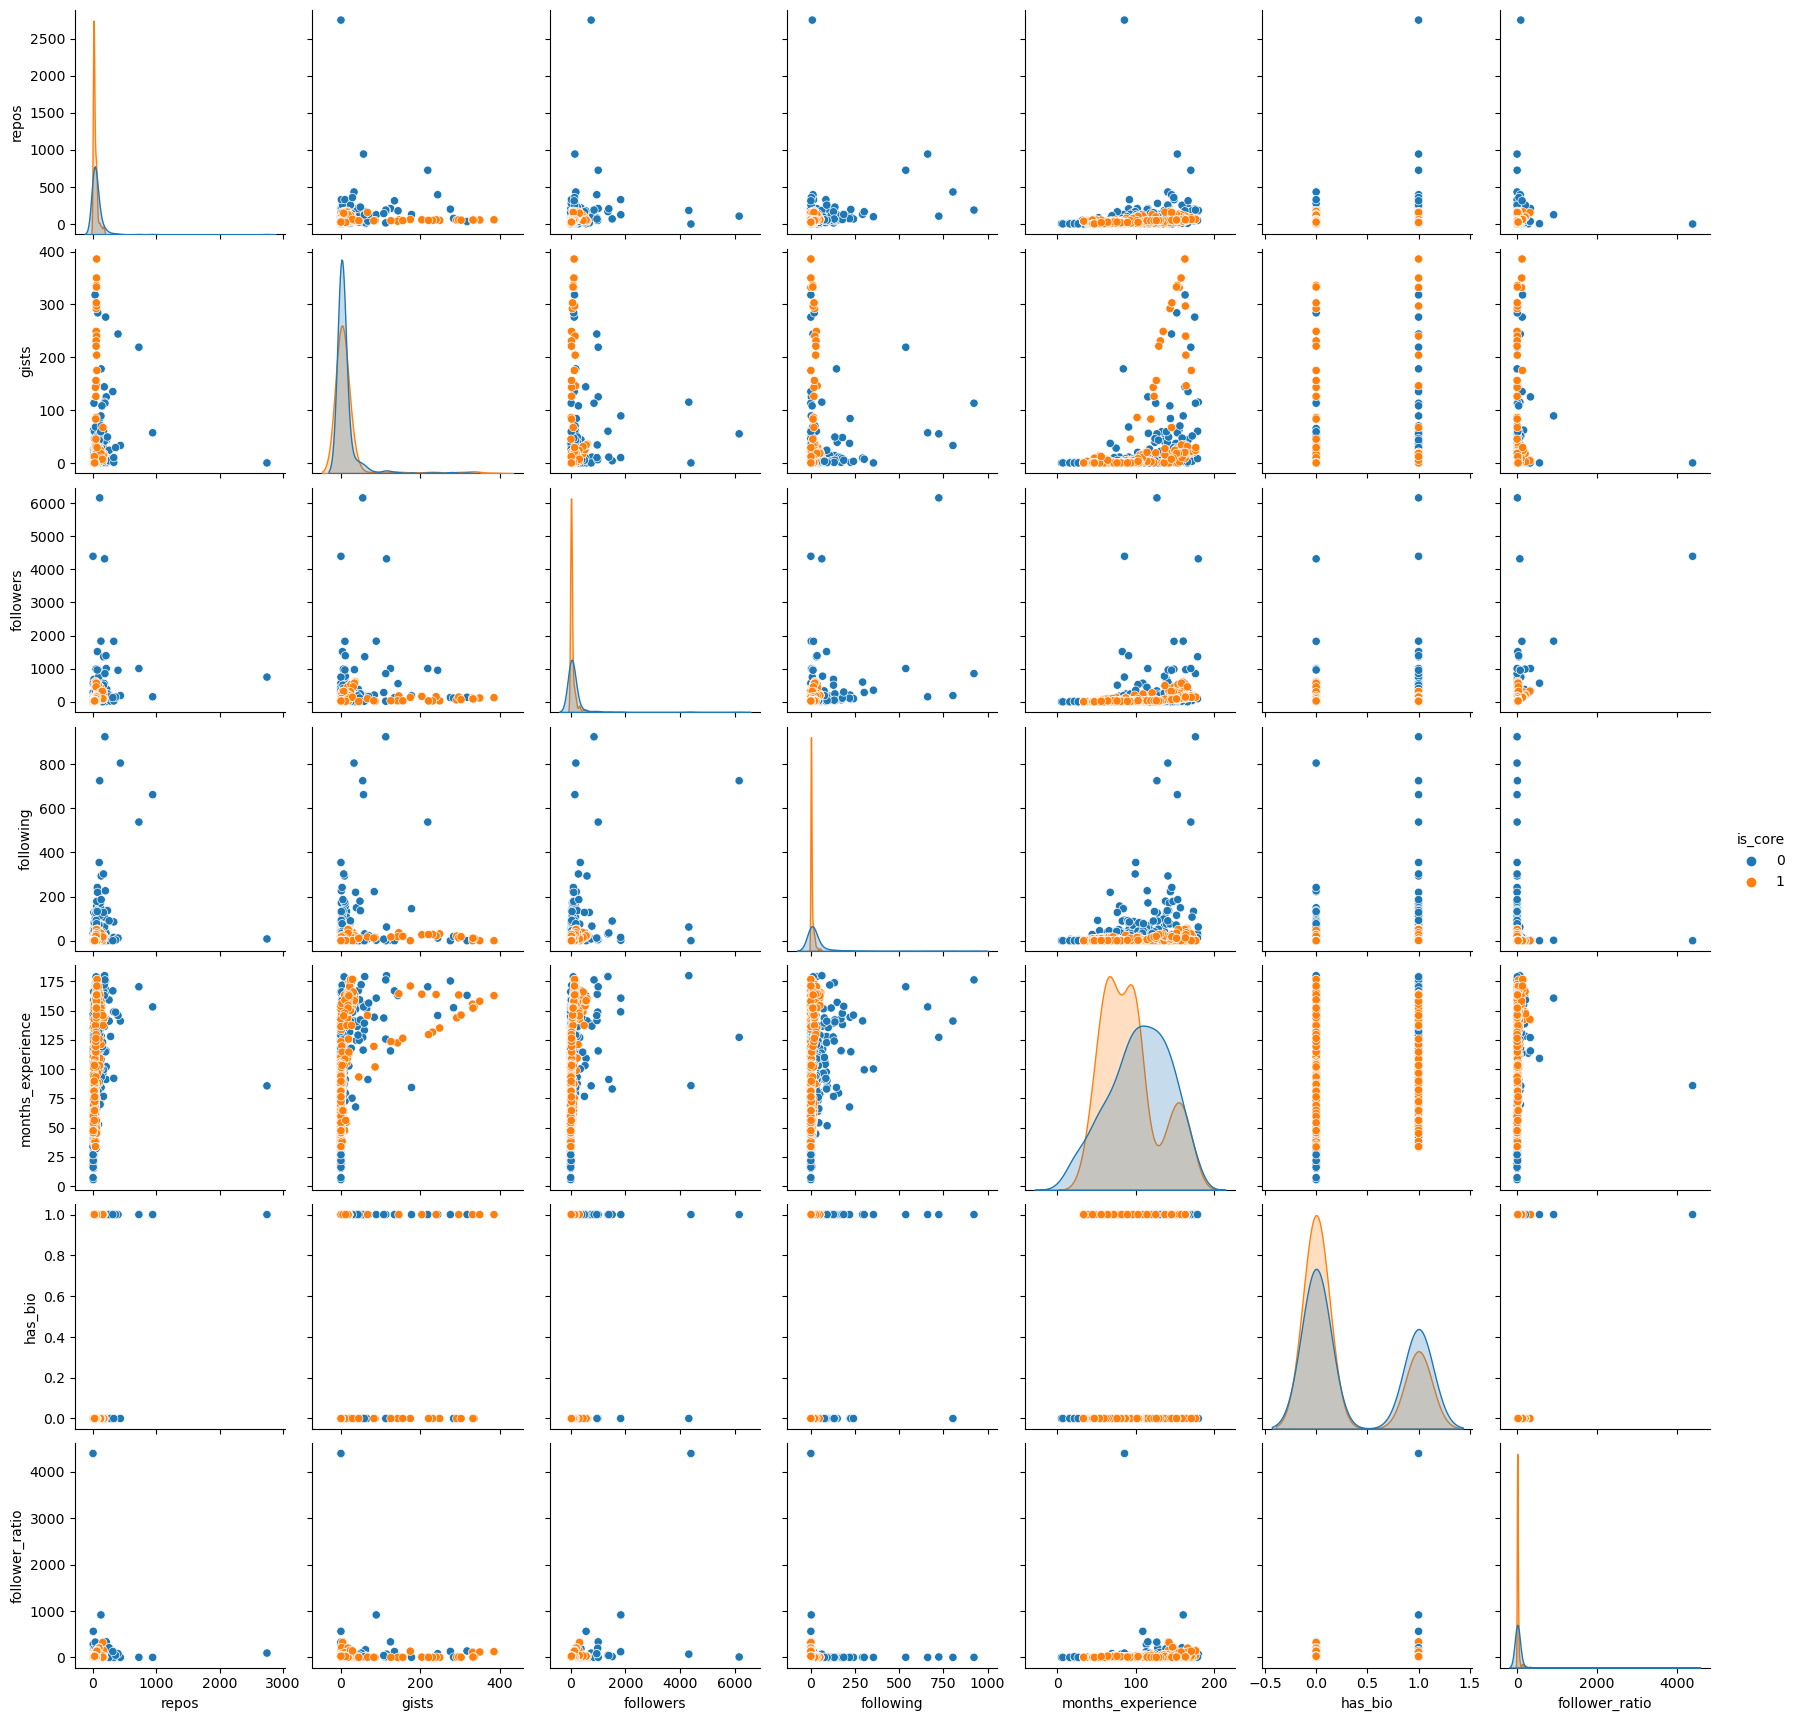

In [10]:
sns.pairplot(c2_train, hue = 'is_core')

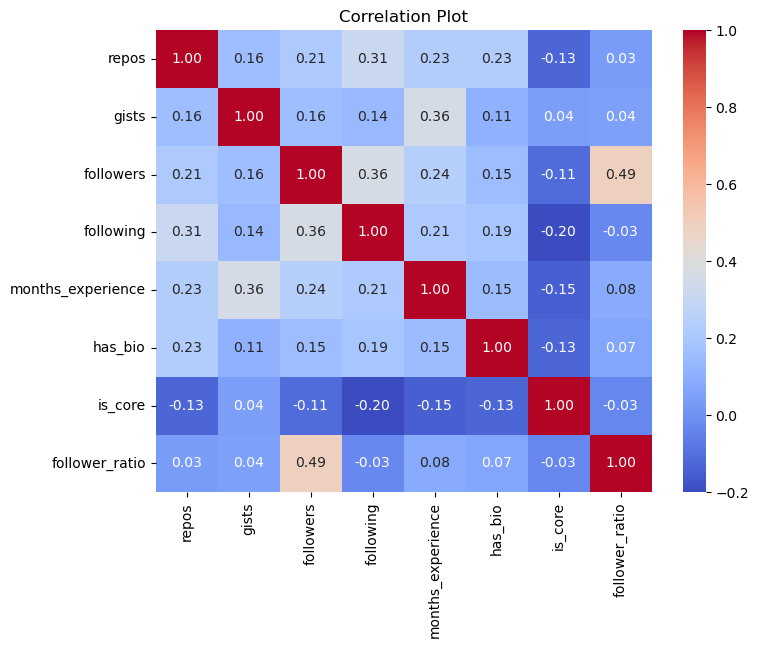

In [11]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c2_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

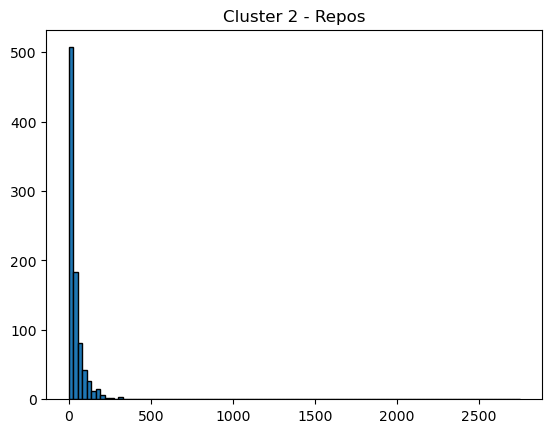

In [12]:
plt.hist(c2_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 2 - Repos')
plt.show()

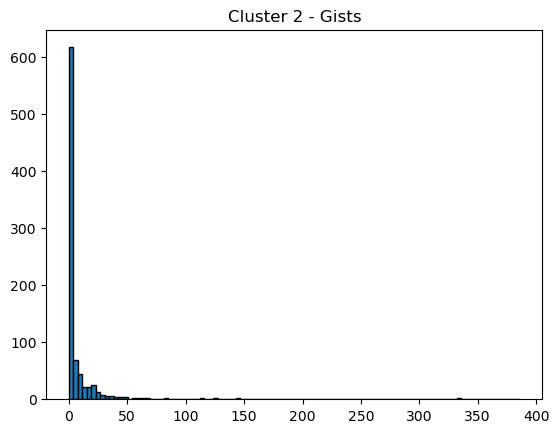

In [13]:
plt.hist(c2_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 2 - Gists')
plt.show()

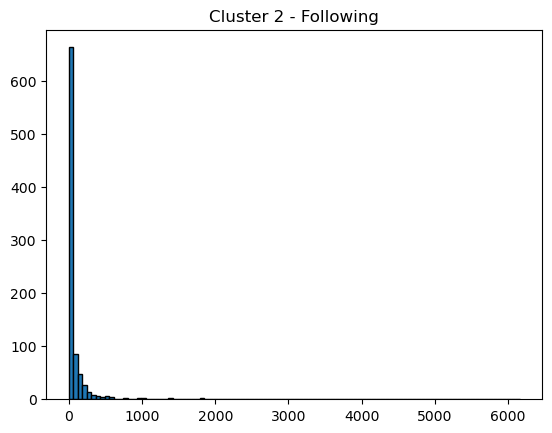

In [14]:
plt.hist(c2_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 2 - Following')
plt.show()

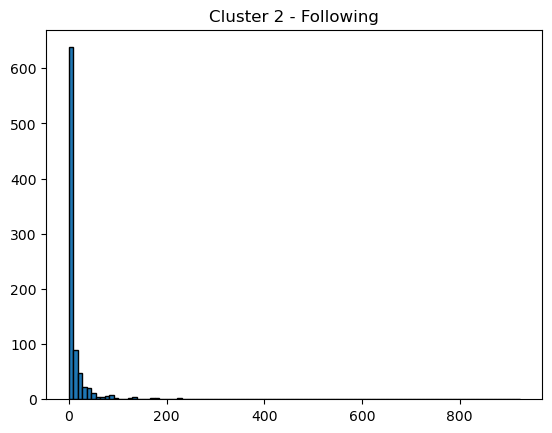

In [15]:
plt.hist(c2_train.following, bins=100, edgecolor='black')
plt.title('Cluster 2 - Following')
plt.show()

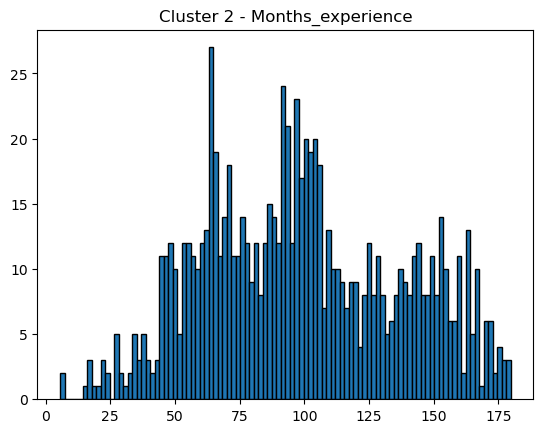

In [16]:
plt.hist(c2_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 2 - Months_experience')
plt.show()

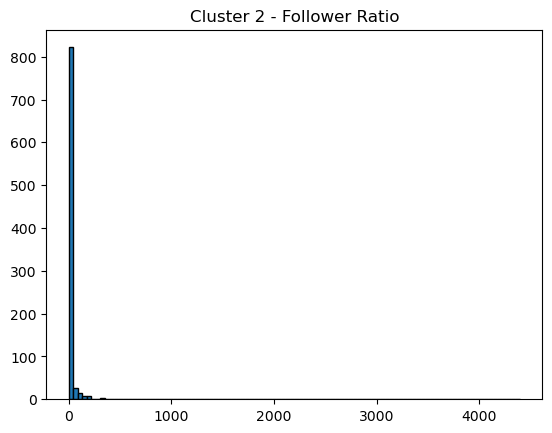

In [17]:
plt.hist(c2_train.follower_ratio, bins=100, edgecolor='black')
plt.title('Cluster 2 - Follower Ratio')
plt.show()

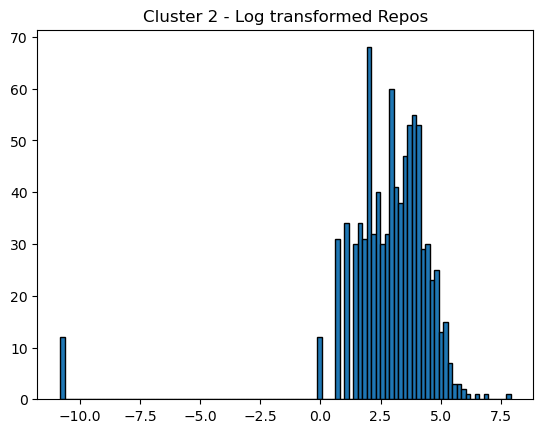

In [18]:
plt.hist(np.log(c2_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Repos')
plt.show()

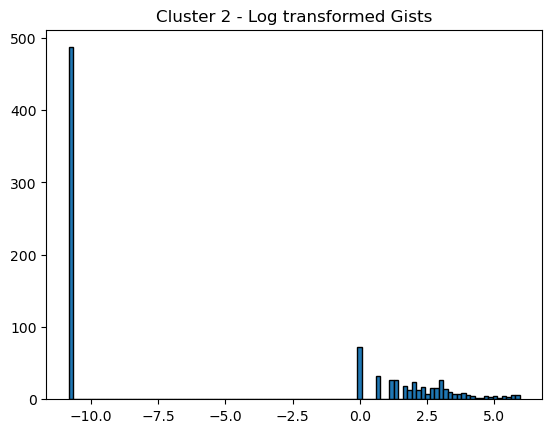

In [19]:
plt.hist(np.log(c2_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Gists')
plt.show()

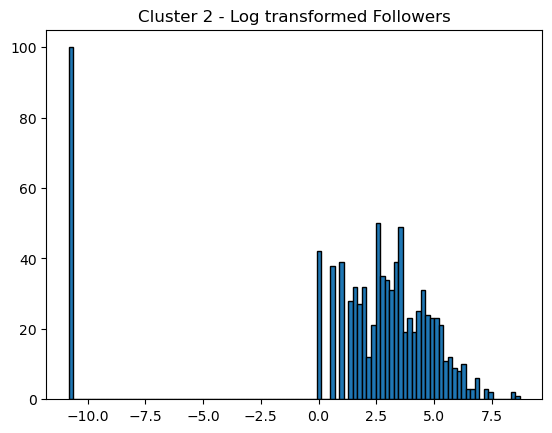

In [20]:
plt.hist(np.log(c2_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Followers')
plt.show()

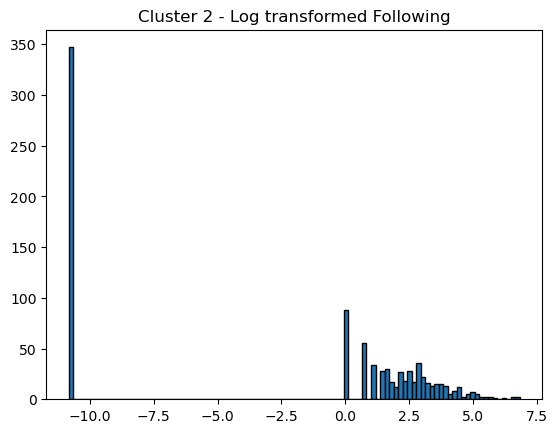

In [21]:
plt.hist(np.log(c2_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Following')
plt.show()

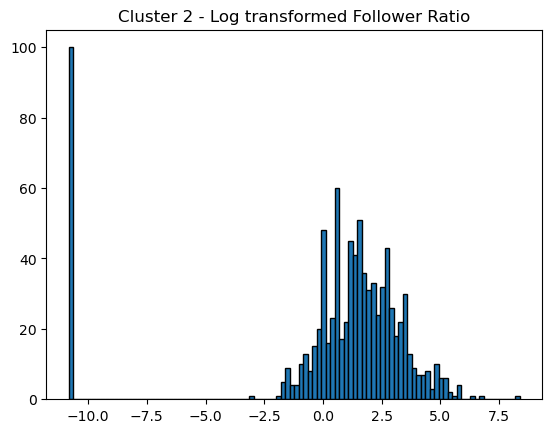

In [22]:
plt.hist(np.log(c2_train.follower_ratio+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 2 - Log transformed Follower Ratio')
plt.show()

In [23]:
c2_train_log = c2_train.copy()
c2_train_log['repos'] = np.log(c2_train_log.repos+2e-5)
c2_train_log['gists'] = np.log(c2_train_log.gists+2e-5)
c2_train_log['followers'] = np.log(c2_train_log.followers+2e-5)
c2_train_log['following'] = np.log(c2_train_log.following+2e-5)
c2_train_log['follower_ratio'] = np.log(c2_train_log.follower_ratio+2e-5)
c2_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,1.099,-10.820,0.000,-10.820,99.200,0,0,0.000
1,1.609,-10.820,-10.820,-10.820,80.570,0,0,-10.820
2,3.555,0.000,3.611,1.946,86.980,0,0,1.665
3,1.099,-10.820,5.638,-10.820,113.630,0,0,5.638
4,4.466,0.693,3.178,3.091,104.600,1,0,0.087
...,...,...,...,...,...,...,...,...
882,3.332,-10.820,3.526,0.693,72.256,1,1,2.833
883,2.996,-10.820,2.708,0.693,89.675,1,1,2.015
884,3.219,1.609,3.296,0.000,64.527,1,1,3.296
885,3.045,2.485,2.890,0.000,56.196,1,1,2.890


In [24]:
test_df['follower_ratio'] = np.where(test_df['following'] == 0, test_df['followers'], test_df['followers'] / test_df['following'])
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
5775,8,2,13,9,15.680,0,0,1.444
4493,2,0,0,0,70.380,0,0,0.000
7312,42,10,3,10,170.680,0,0,0.300
4453,1,0,0,0,28.550,0,0,0.000
4531,86,3,4,14,114.480,0,0,0.286
...,...,...,...,...,...,...,...,...
6074,163,72,2913,0,145.990,0,0,2913.000
5777,19,1,18,11,53.460,1,0,1.636
4423,17,1,20,6,139.660,0,1,3.333
6147,28,0,12,46,66.220,0,0,0.261


In [25]:
test_df['repos'] = np.log(test_df.repos+2e-5)
test_df['gists'] = np.log(test_df.gists+2e-5)
test_df['followers'] = np.log(test_df.followers+2e-5)
test_df['following'] = np.log(test_df.following+2e-5)
test_df['follower_ratio'] = np.log(test_df.follower_ratio+2e-5)
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
5775,2.079,0.693,2.565,2.197,15.680,0,0,0.368
4493,0.693,-10.820,-10.820,-10.820,70.380,0,0,-10.820
7312,3.738,2.303,1.099,2.303,170.680,0,0,-1.204
4453,0.000,-10.820,-10.820,-10.820,28.550,0,0,-10.820
4531,4.454,1.099,1.386,2.639,114.480,0,0,-1.253
...,...,...,...,...,...,...,...,...
6074,5.094,4.277,7.977,-10.820,145.990,0,0,7.977
5777,2.944,0.000,2.890,2.398,53.460,1,0,0.492
4423,2.833,0.000,2.996,1.792,139.660,0,1,1.204
6147,3.332,-10.820,2.485,3.829,66.220,0,0,-1.344


In [26]:
scaler = StandardScaler()
X_std = c2_train_log.drop(columns=['has_bio', 'is_core'])
x2 = c2_train_log[['has_bio', 'is_core']]
X_std = scaler.fit_transform(X_std)
train = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
train = pd.concat([train, x2], axis = 1)
train

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,-0.853,-0.895,-0.329,-1.226,0.010,-0.066,0,0
1,-0.601,-0.895,-2.637,-1.226,-0.482,-2.631,0,0
2,0.358,0.768,0.441,0.764,-0.312,0.329,0,0
3,-0.853,-0.895,0.874,-1.226,0.391,1.271,0,0
4,0.807,0.875,0.349,0.943,0.153,-0.045,1,0
...,...,...,...,...,...,...,...,...
882,0.248,-0.895,0.423,0.569,-0.701,0.606,1,1
883,0.082,-0.895,0.249,0.569,-0.241,0.412,1,1
884,0.192,1.015,0.374,0.461,-0.905,0.715,1,1
885,0.107,1.150,0.288,0.461,-1.125,0.619,1,1


In [27]:
X_std = test_df.drop(columns=['has_bio', 'is_core'])
x2 = test_df[['has_bio', 'is_core']]
X_std = scaler.transform(X_std)
test = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
test = test.reset_index(drop=True)
x2 = x2.reset_index(drop=True)
test = pd.concat([test, x2], axis = 1)
test

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,-0.369,0.875,0.218,0.804,-2.194,0.021,0,0
1,-1.053,-0.895,-2.637,-1.226,-0.751,-2.631,0,0
2,0.448,1.122,-0.095,0.820,1.897,-0.351,0,0
3,-1.395,-0.895,-2.637,-1.226,-1.855,-2.631,0,0
4,0.802,0.937,-0.033,0.872,0.413,-0.363,0,0
...,...,...,...,...,...,...,...,...
114,1.117,1.425,1.373,-1.226,1.245,1.825,0,0
115,0.057,0.768,0.288,0.835,-1.197,0.051,1,0
116,0.002,0.768,0.310,0.740,1.078,0.220,0,1
117,0.248,-0.895,0.201,1.058,-0.860,-0.384,0,0


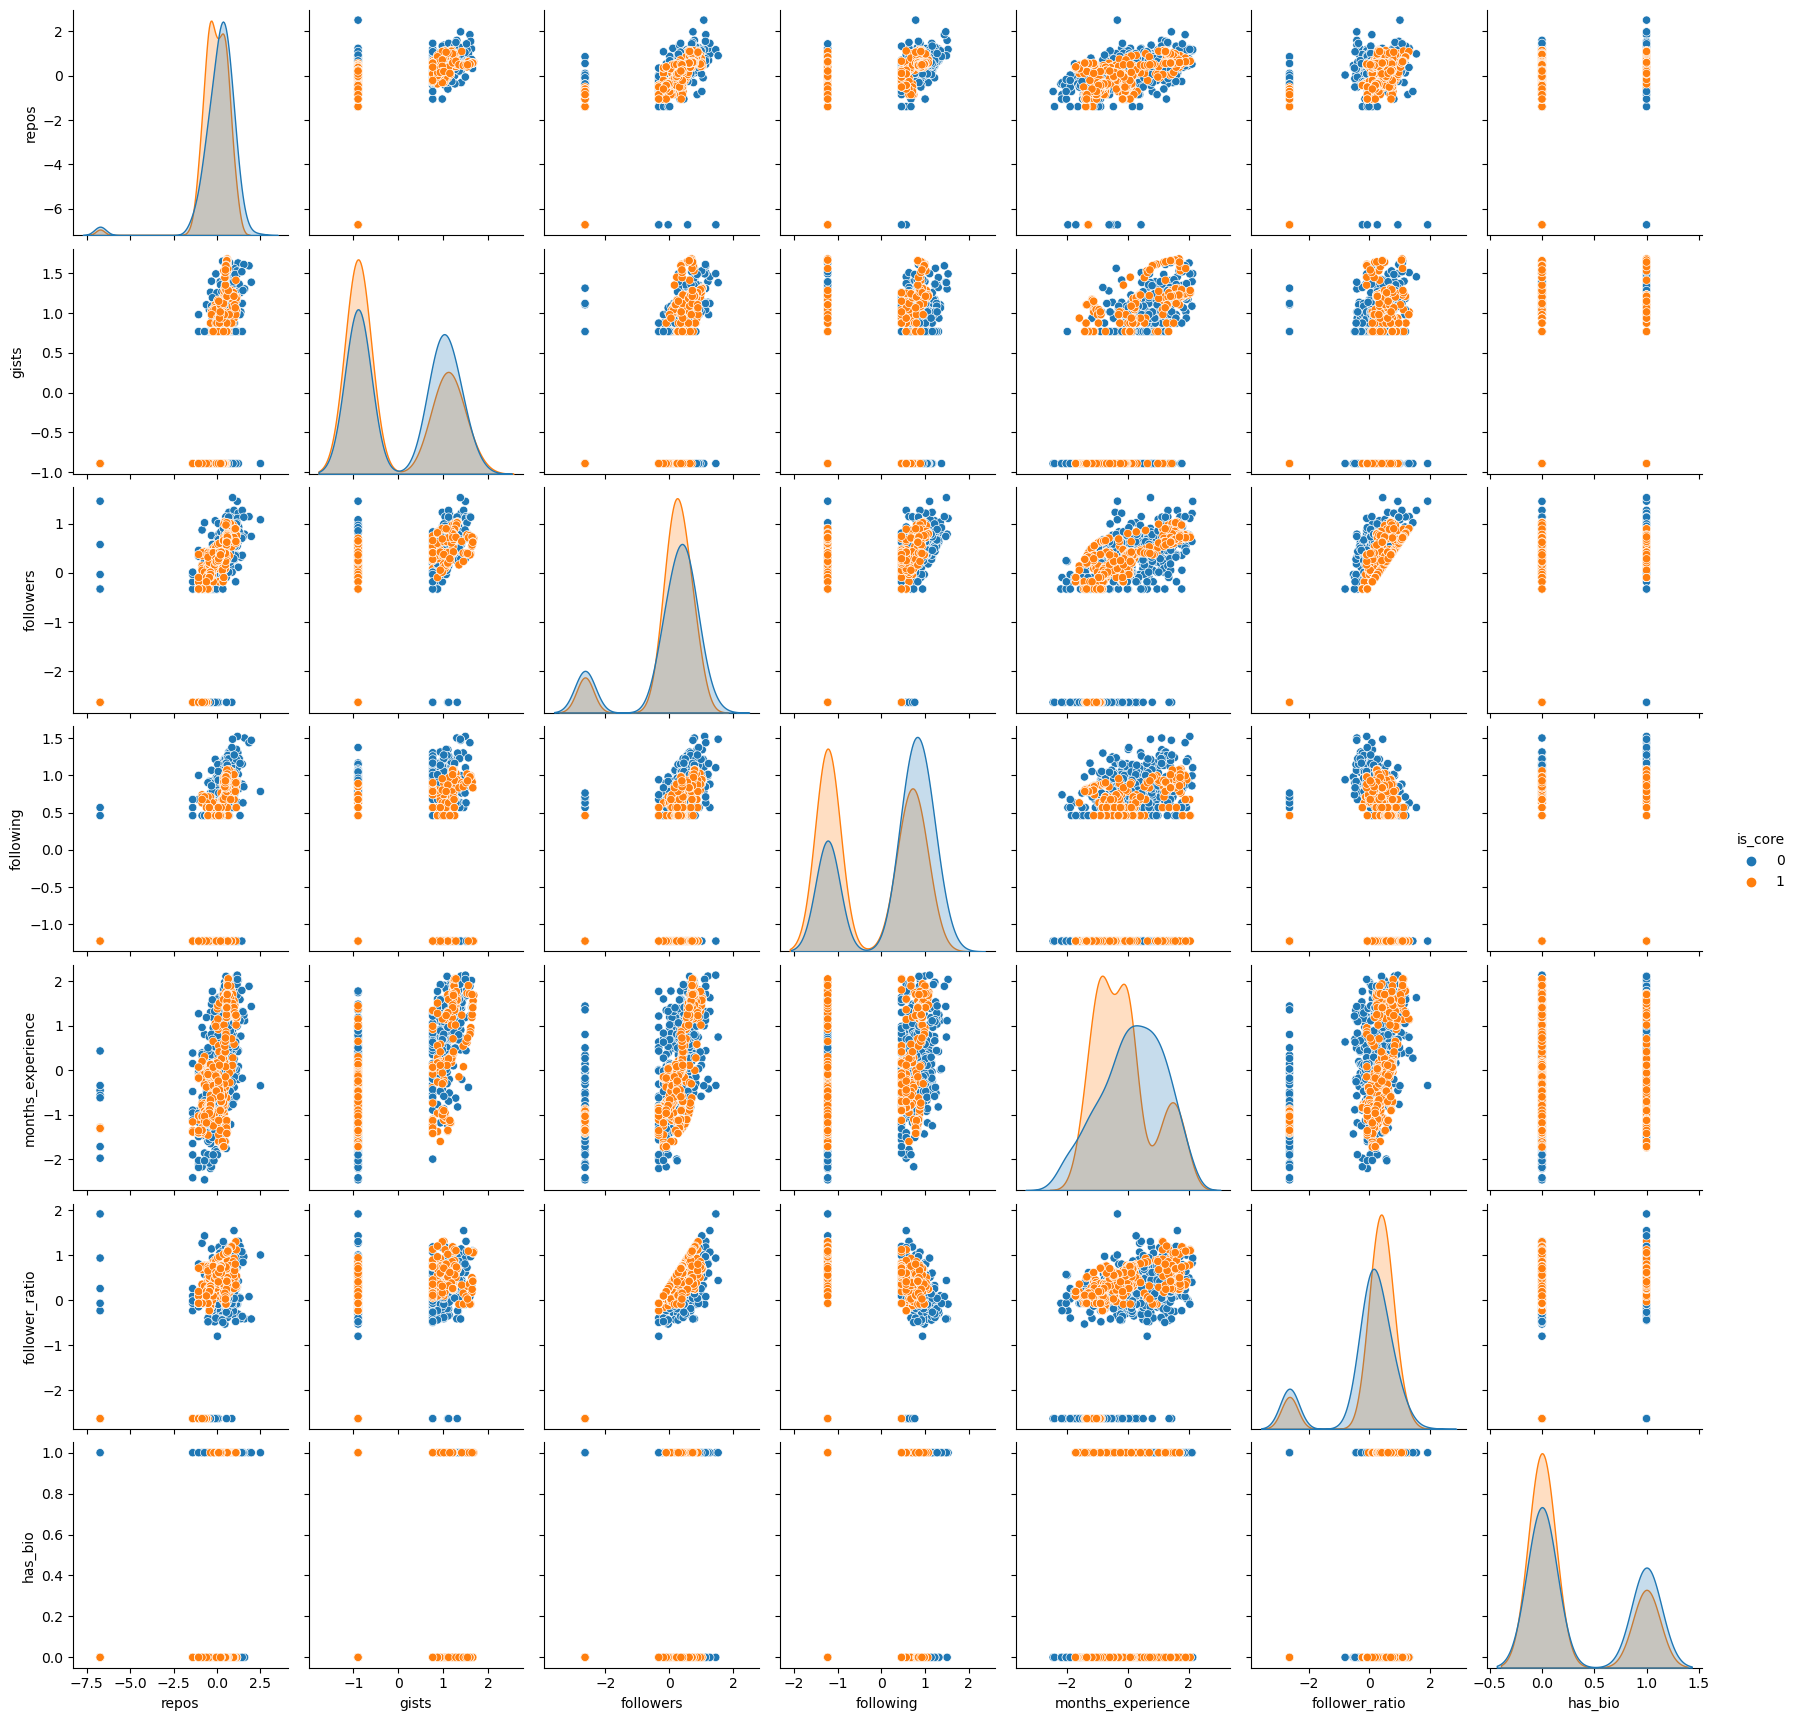

In [28]:
sns.pairplot(train, hue = 'is_core')

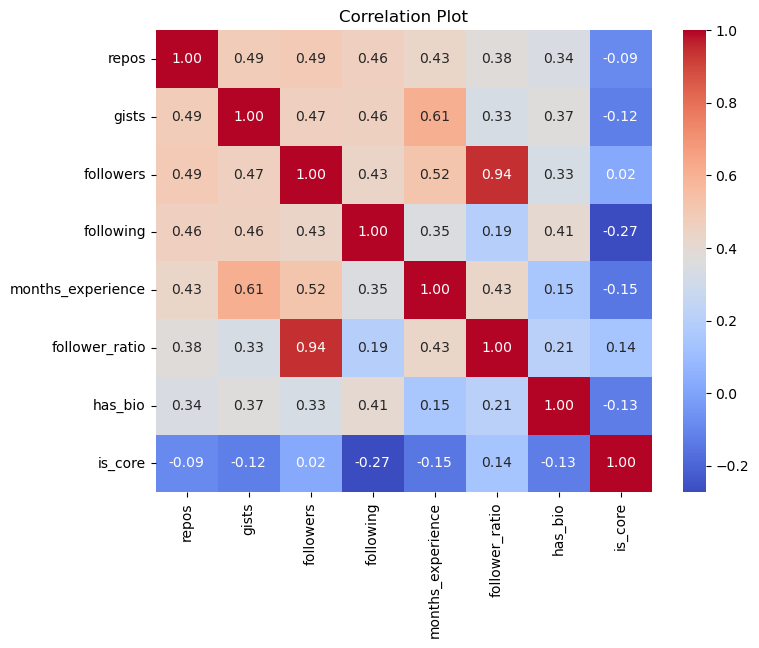

In [29]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

In [30]:
X = train.drop('is_core', axis=1)
y = train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0462
gists: 0.0369
followers: 0.0494
following: 0.0998
months_experience: 0.0884
follower_ratio: 0.0795
has_bio: 0.0082


In [31]:
train['has_bio'] = pd.Categorical(train['has_bio'])
train['has_bio'] = pd.Categorical(train['has_bio'])

test['is_core'] = pd.Categorical(test['is_core'])
test['is_core'] = pd.Categorical(test['is_core'])

X_train = train.drop(columns = "is_core")
X_test = test.drop(columns = 'is_core')

y_train = train['is_core']
y_test = test['is_core']

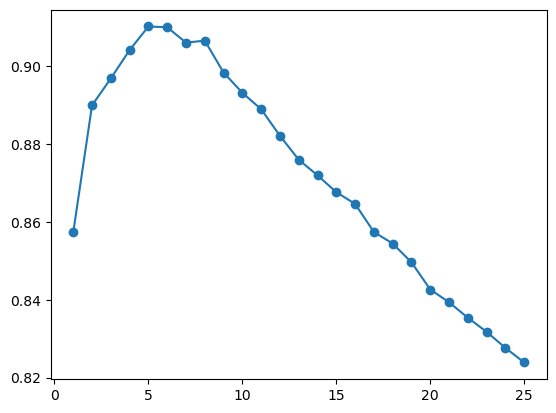

In [32]:
# Create a KNN classifier
k_vals = list(range(1, 26))
scores = []

for k in k_vals:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (n_neighbors) as needed

    # Perform 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=kf, scoring = 'roc_auc')

    scores.append(np.mean(cv_scores))
    
plt.plot(k_vals, scores, marker='o', linestyle='-')
plt.show()

In [33]:
max_k = scores.index(max(scores))+1
knn_classifier = KNeighborsClassifier(n_neighbors=max_k)
knn_classifier.fit(X_train, y_train)


y_pred = knn_classifier.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[78 33]
 [ 4  4]]

Test Set Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       111
           1       0.11      0.50      0.18         8

    accuracy                           0.69       119
   macro avg       0.53      0.60      0.49       119
weighted avg       0.89      0.69      0.77       119



In [34]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [0.5, 0.6, 0.7]
}


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", rf_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(rf_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
rf_best_model = rf_grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 0.49 Minutes

Best Hyperparameters: {'max_depth': 10, 'max_samples': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.88
Confusion Matrix:
[[93 18]
 [ 6  2]]

Test Set Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       111
           1       0.10      0.25      0.14         8

    accuracy                           0.80       119
   macro avg       0.52      0.54      0.51       119
weighted avg       0.88      0.80      0.84       119



In [35]:
y_pred = rf_best_model.predict(X_train)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_train, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[405  35]
 [  0 447]]

Test Set Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       440
           1       0.93      1.00      0.96       447

    accuracy                           0.96       887
   macro avg       0.96      0.96      0.96       887
weighted avg       0.96      0.96      0.96       887



In [36]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3, 5, 10, 25],
    'min_samples_leaf': [2, 3, 5, 10]
}


# Initialize the DT Classifier
clf = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Initialize GridSearchCV with 10-fold cross-validation
dt_grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
dt_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", dt_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(dt_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
dt_best_model = dt_grid_search.best_estimator_
y_pred = dt_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Search completed in 0.0 Minutes

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3}
Best Cross-Validation Accuracy: 0.77
Confusion Matrix:
[[89 22]
 [ 5  3]]

Test Set Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       111
           1       0.12      0.38      0.18         8

    accuracy                           0.77       119
   macro avg       0.53      0.59      0.53       119
weighted avg       0.89      0.77      0.82       119



In [37]:
y_pred = dt_best_model.predict(X_train)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_train, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[385  55]
 [ 16 431]]

Test Set Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       440
           1       0.89      0.96      0.92       447

    accuracy                           0.92       887
   macro avg       0.92      0.92      0.92       887
weighted avg       0.92      0.92      0.92       887



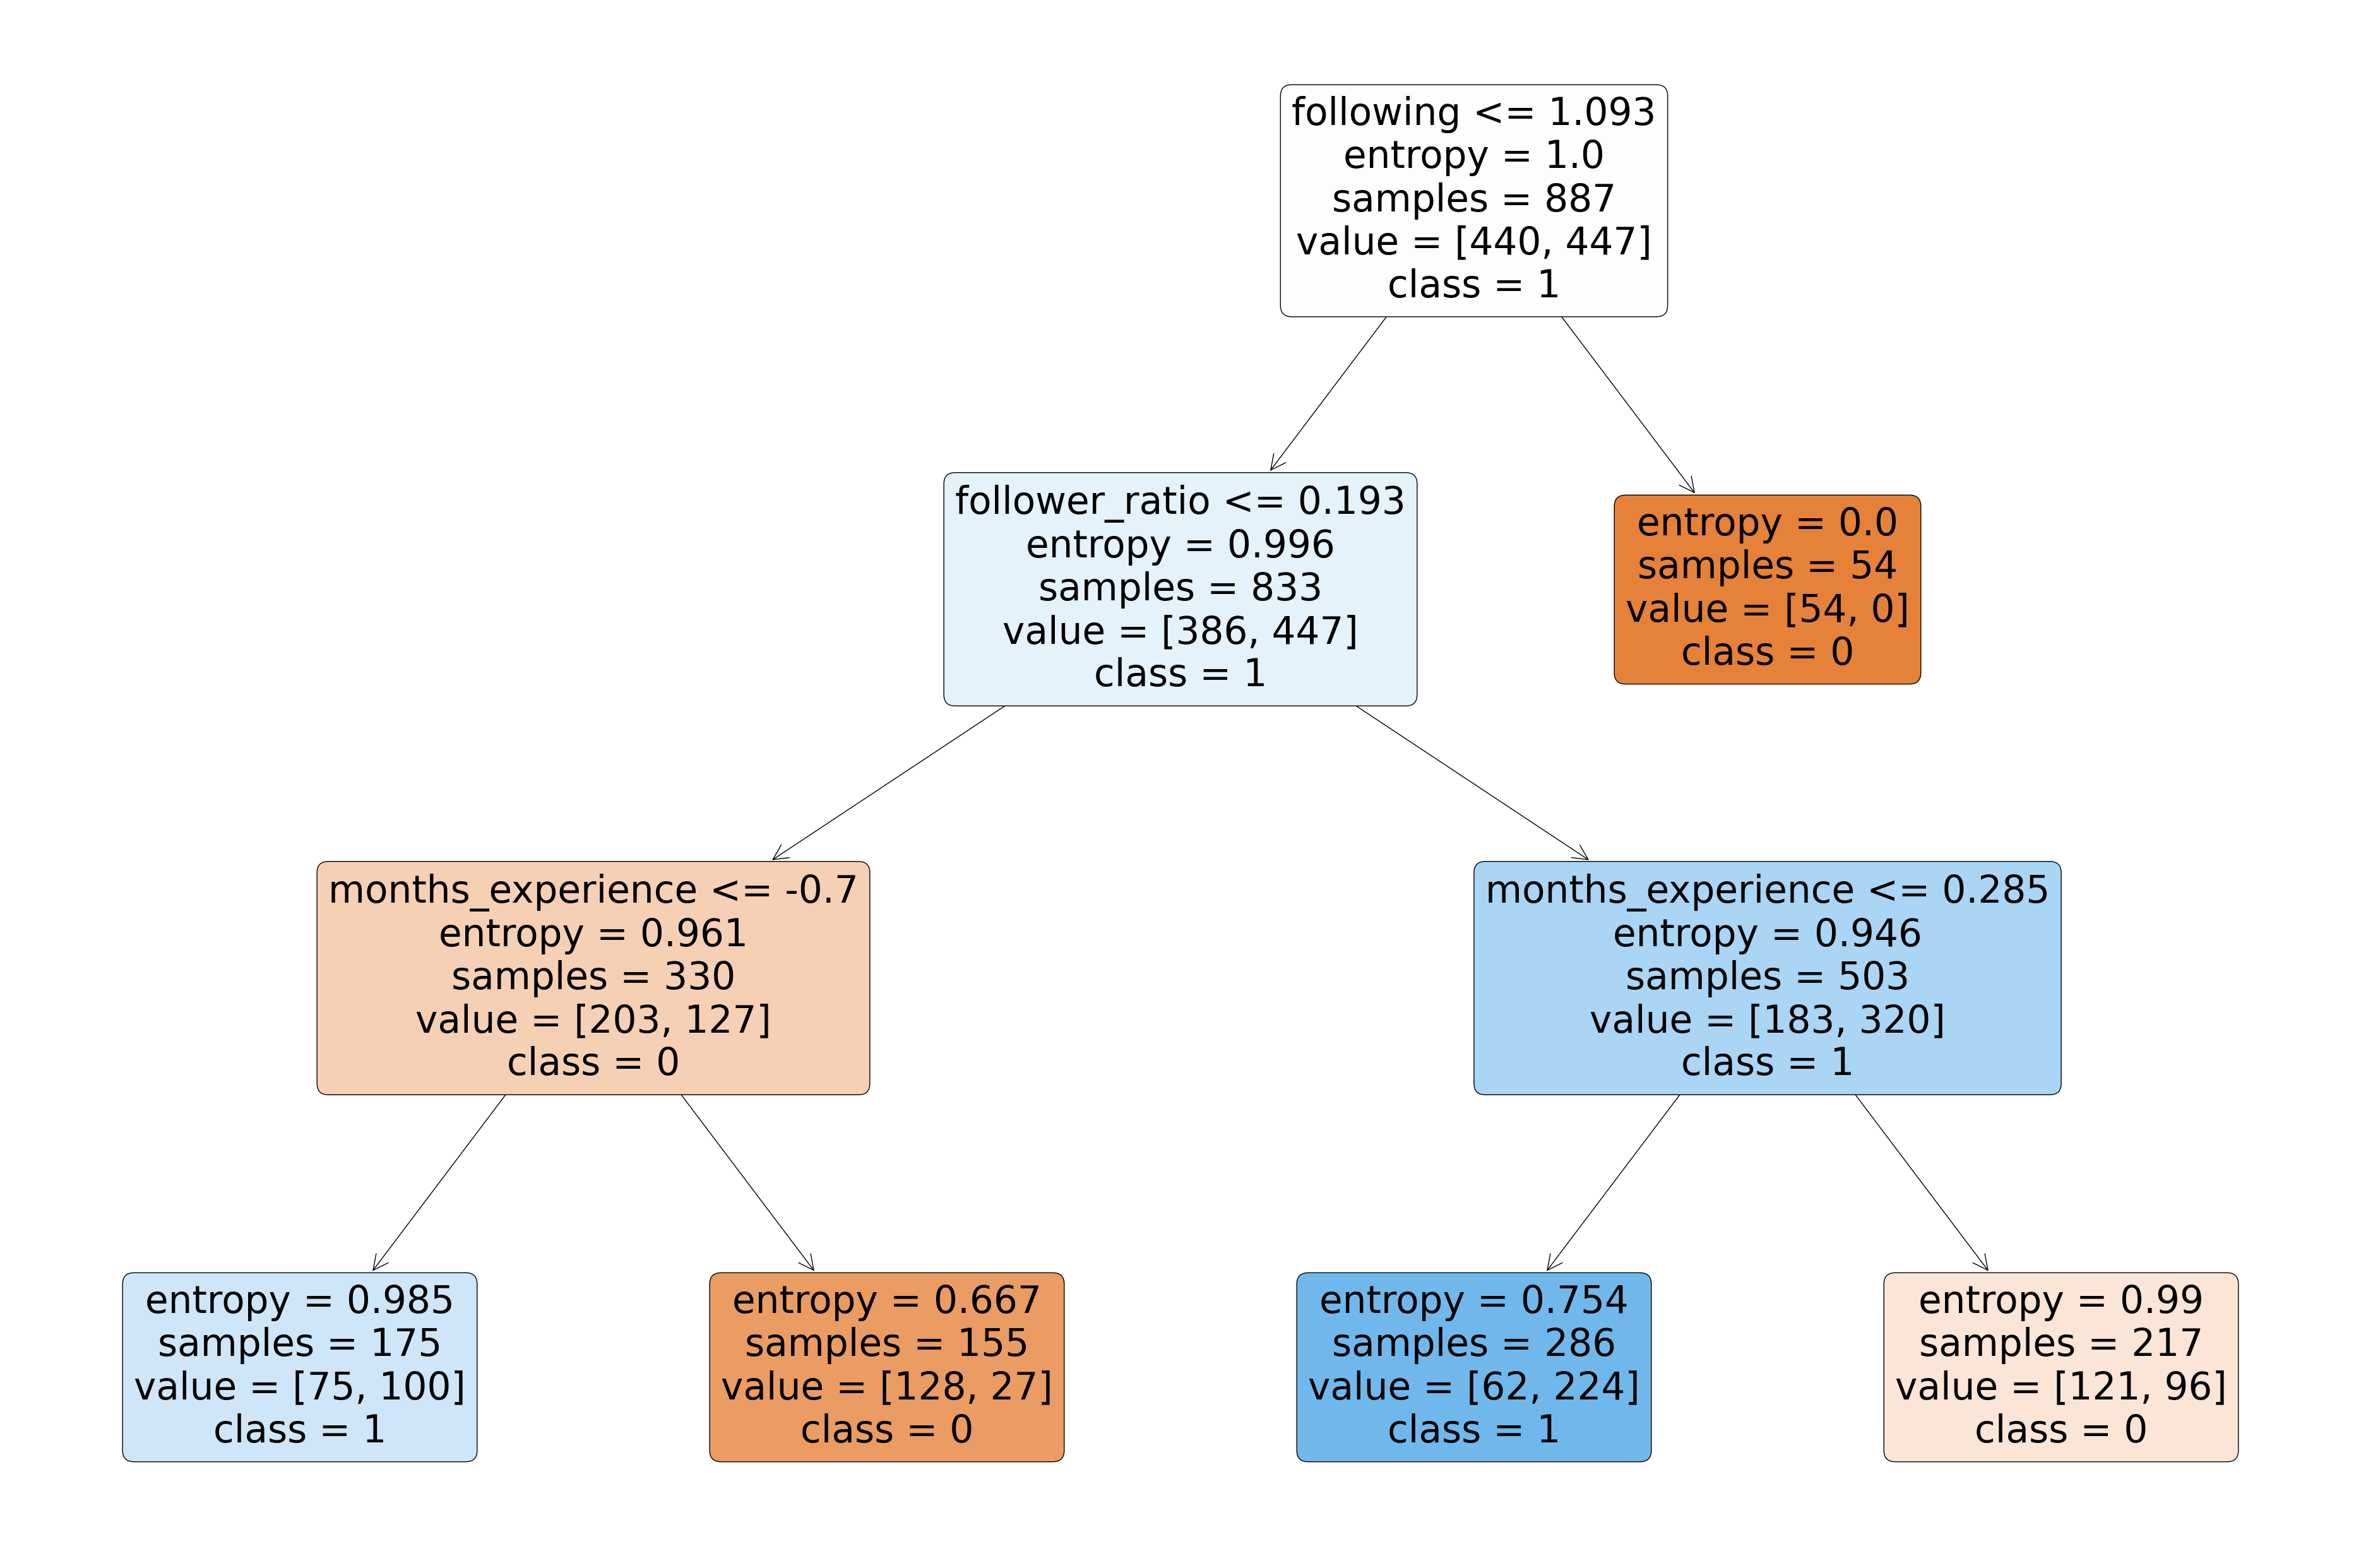

In [38]:
clf = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(48, 32))
tree.plot_tree(clf, filled = True, rounded = True, feature_names = X_train.columns, class_names = y_train.unique().astype(str).tolist())
plt.show()

In [39]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


# Initialize the Random Forest Classifier
xgboost = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
xg_grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
xg_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", xg_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(xg_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
xg_best_model = xg_grid_search.best_estimator_
y_pred = xg_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 0.79 Minutes

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.90
Confusion Matrix:
[[92 19]
 [ 6  2]]

Test Set Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       111
           1       0.10      0.25      0.14         8

    accuracy                           0.79       119
   macro avg       0.52      0.54      0.51       119
weighted avg       0.88      0.79      0.83       119



In [40]:
# Define the logistic regression model
logistic_regression = LogisticRegression(solver = 'saga', random_state = 42)

# Define the hyperparameter grid to search through
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10],                  # Inverse of regularization strength              # Algorithm to use in the optimization problem
    'l1_ratio': [0.1, 0.5, 0.9],                    # Elastic Net mixing parameter (used when penalty='elasticnet')
}

# Initialize GridSearchCV
log_grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)
t1 = time.time()
# Fit the grid search to the data
log_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Search completed in 0.01 Minutes



C:\Users\Ethan Smith\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [41]:
# Print the best hyperparameters
print("Best Hyperparameters:", log_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(log_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
log_best_model = log_grid_search.best_estimator_
y_pred = log_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best Cross-Validation Accuracy: 0.69
Confusion Matrix:
[[86 25]
 [ 4  4]]

Test Set Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       111
           1       0.14      0.50      0.22         8

    accuracy                           0.76       119
   macro avg       0.55      0.64      0.54       119
weighted avg       0.90      0.76      0.81       119

